In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

SEED = 21
plt.rcParams["figure.figsize"] = (6.4/2, 4.8/2)

### Read in the data

In [2]:
data = pd.read_pickle("../Data/GSE115978-allData.pkl")
macrophage = (data["cellType"] == "Macrophage")
data.insert(2, "macrophage", macrophage)
data

,cellID,cellType,macrophage,C9orf152,RPS11,ELMO2,CREB3L1,PNMA1,MMP2,TMEM216,...,MIR4691,GPLD1,RAB8A,RXFP2,PCIF1,PIK3IP1,SNRPD2,SLC39A6,CTSC,AQP7
0,GSM3197115,Mal,False,0.0,2.067933,1.517847,0.0,1.686722,1.168448,1.526162,...,0.000000,0.367588,1.496530,0.0,0.000000,0.966075,1.876721,1.638426,1.512449,0.0
1,GSM3197116,Mal,False,0.0,1.922102,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,1.802701,1.909713,0.000000,0.000000,0.000000,0.0
2,GSM3197117,Mal,False,0.0,2.015497,0.841959,0.0,0.695306,0.000000,0.000000,...,0.000000,1.127459,0.000000,0.0,0.000000,0.000000,1.882266,1.141858,1.459023,0.0
3,GSM3197118,Mal,False,0.0,1.930309,1.691069,0.0,1.592092,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.947145,1.666798,1.047136,0.0
4,GSM3197119,Mal,False,0.0,2.058619,1.509809,0.0,1.748345,1.676507,1.527963,...,0.000000,0.624097,1.686261,0.0,1.601311,1.379246,1.924609,1.715210,1.352315,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7181,GSM3204296,T.CD8,False,0.0,1.924485,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.617210,1.937055,0.0,0.000000,0.000000,1.986266,0.000000,1.991558,0.0
7182,GSM3204297,T.CD8,False,0.0,1.977320,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.636619,0.000000,0.0,1.941190,1.212302,0.000000,0.000000,1.324604,0.0
7183,GSM3204298,T.CD8,False,0.0,1.986248,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.868394,0.000000,0.0,1.997277,0.000000,0.000000,0.000000,1.601028,0.0
7184,GSM3204299,T.CD8,False,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,1.868568,1.488624,0.000000,0.0,0.000000,0.000000,1.668218,0.000000,1.948110,0.0


### Train logistic regression model

In [3]:
all_features = data.columns.tolist()[2:]
reshape1D = lambda x:np.array(x).reshape(-1,1)

def plotConfusionMat(mat, class_names):
    ''''Visualize confusion matrix in array format to heatmap.'''
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(mat), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    return fig

def macLogReg(features=all_features, labels="macrophage", test_size=0.2, showMetrics=True):
    ''''Train and evaluate logistic regression model for macrophage dataset.'''
    X = data[features] # Features
    y = data[labels] # Target labels
    
    # Define train/test split, stratify to ensure same distribution of classes
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED, stratify=y)
    
    # Reshape arrays
    if len(features) == 1:
        X_train = reshape1D(X_train)
        X_test = reshape1D(X_test)
    else:
        y_train = y_train.ravel()
    
    # Initialize model
    logreg = LogisticRegression(random_state=SEED)
    # Train model
    logreg.fit(X_train, y_train)
    # Make predictions
    y_pred = logreg.predict(X_test)
    
    # Plot confusion matrix
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    class_names=[0,1] # name  of classes
    cnf_matrix = plotConfusionMat(cnf_matrix, class_names)
    
    # Metrics
    y_pred_proba = logreg.predict_proba(X_test)[::,1]
    metrics_dict = {}
    metrics_dict['auc'] = metrics.roc_auc_score(y_test, y_pred_proba)
    metrics_dict['f1score'] = metrics.f1_score(y_test, y_pred)
    metrics_dict['accuracy'] = metrics.accuracy_score(y_test, y_pred)
    
    if showMetrics:
        for key, value in metrics_dict.items():
            print(f'{key: <10}{value: <15}')
        
    return logreg, y_pred, cnf_matrix, metrics_dict

### Try on known combinations of marker genes

auc       0.9925529295913345
f1score   0.8105263157894737
accuracy  0.9749652294853964


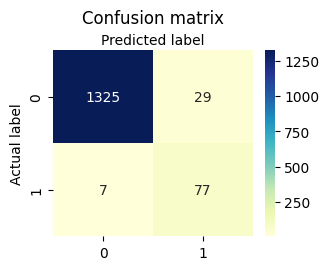

In [4]:
reg = macLogReg(features=["TYROBP", "FCER1G"])

auc       0.9798920306675106
f1score   0.802030456852792
accuracy  0.9728789986091794


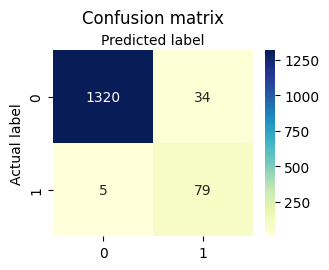

In [5]:
reg = macLogReg(features=["TYROBP"])

auc       0.9706073714567067
f1score   0.7567567567567568
accuracy  0.9687065368567455


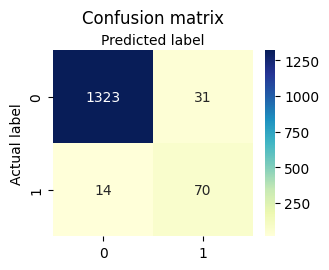

In [6]:
reg = macLogReg(features=["FCER1G"])

auc       0.8995480762467468
f1score   0.8170731707317073
accuracy  0.9791376912378303


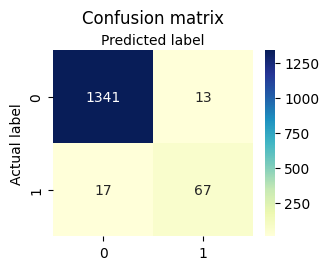

In [7]:
reg = macLogReg(features=["CD14"])